In [1]:
import anndata
import os
import requests

def read_link(link, save_path):
    if not os.path.exists(save_path):
        response = requests.get(link)
        with open(save_path, "wb") as f:
            f.write(response.content)

    return anndata.read_h5ad(save_path)

MOBSC_sce = read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad")
MOBSP_sce = read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")

exper = {
    "sc": read_link("https://go.wisc.edu/yeo402", "data/MOBSC_sce.h5ad"),
    "sp": read_link("https://go.wisc.edu/n7bcr6", "data/MOBSP_sce.h5ad")
    }

We haven't implemented differential variance in the current copula estimator! This is a simple extension -- let's make sure to add it.

In [2]:
from scdesigner.simulators import NegBinCopulaSimulator

formulas = {"sc": "~ cellType", "sp": "~ bs(spatial1, df=40) + bs(spatial2, df=40)"}
sims = {k: NegBinCopulaSimulator(lr=0.01) for k in exper.keys()}
{v.fit(exper[k], formulas[k]) for k, v in sims.items()}

{None}

We need also a function to get the mean matrices. This is like "predict" in R.

In [3]:
means = {k: v.predict(exper[k].obs)["mean"] for k, v in sims.items()}

In [4]:
means

{'sc':                         Grin2b     Prkca      Ano3     Gria3     Kank3  \
 WT1_AAACCTGAGCTGCGAA  1.793055  0.928274  0.674649  0.616920  0.635457   
 WT1_AAACCTGGTTTGGCGC  1.793055  0.928274  0.674649  0.616920  0.635457   
 WT1_AAACGGGAGATCCGAG  1.793055  0.928274  0.674649  0.616920  0.635457   
 WT1_AAACGGGGTAAGTGGC  1.793055  0.928274  0.674649  0.616920  0.635457   
 WT1_AAAGATGTCATCGGAT  0.787146  0.205400  0.077358  0.078780  0.172530   
 ...                        ...       ...       ...       ...       ...   
 OC2_TAAGTGCGTTTGTTGG  0.324258  0.222504  0.152327  0.145257  0.153372   
 OC2_TACGGTAGTAAATGTG  0.324258  0.222504  0.152327  0.145257  0.153372   
 OC2_TACTTACGTAGGCATG  0.324258  0.222504  0.152327  0.145257  0.153372   
 OC2_TAGTTGGTCGCGATCG  0.324258  0.222504  0.152327  0.145257  0.153372   
 OC2_TTGCGTCAGGATCGCA  0.324258  0.222504  0.152327  0.145257  0.153372   
 
                           Penk     Icam5    Sema3c     Kcnb2  Il1rapl1  ...  \
 WT1_AAACCTG

In [5]:
exper["sc_sim"] = sims["sc"].sample(exper["sc"].obs)
zero_ix = exper["sc_sim"].X.sum(axis=0) == 0
exper["sc_sim"].X[0, zero_ix]  = 1

In [6]:
import tangram as tg
from copy import deepcopy

mean_adata = {k: deepcopy(v) for k, v in exper.items()}
for k in ["sp", "sc"]:
    mean_adata[k].X = means[k]

cell_types = list(exper["sc"].obs["cell_type"].dtype.categories)
tg.pp_adatas(exper["sc_sim"], mean_adata["sp"])
adata_map = tg.map_cells_to_space(exper["sc_sim"], mean_adata["sp"])

INFO:root:182 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:182 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 182 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.975, KL reg: 0.002
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000


INFO:root:Saving results..


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


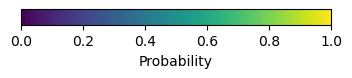

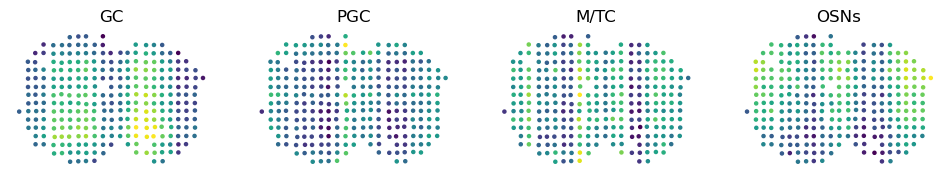

In [7]:
import tangram.plot_utils as pl

pl.plot_cell_annotation(adata_map, mean_adata["sp"], x="spatial1", y="spatial2", ncols=4)

In [8]:
tg.project_cell_annotations(adata_map, exper["sp"])
mixtures = mean_adata["sp"].obsm["tangram_ct_pred"]

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [9]:
import numpy as np

exper["sp_sim"] = exper["sp"].copy()
exper["sp_sim"].X = np.zeros_like(exper["sp"].X)
n_cells = len(exper["sp"])
cells_per_spot = 50, 5

There seem to be two approaches to simulation. In the first, we sample from the simulated single cell matrix without referring to cell type signatures. This is implemented the approach below.

In [10]:
exper["sp_sim"] = exper["sp"].copy()

for n in range(n_cells):
    for k in cell_types:
        # get a random subset of cells of this type
        candidate = np.where(exper["sc_sim"].obs["cell_type"] == k)[0]
        ix = np.random.choice(candidate, size=cells_per_spot[0])

        # simulate according to the deconvolution result
        depths = exper["sc_sim"].X[ix, :].sum(axis=0)
        exper["sp_sim"].X[[n], :] += np.ceil(depths * mixtures[k][n] / cells_per_spot[1])

In the second approach, we derive cell type signatures using the simulated data. We can then create a simulated spatial dataset by taking the outer product between the deconvolution mixtures and the estimated signatures.

In [11]:
signatures = np.zeros((len(cell_types), exper["sc"].n_vars))
for k, cell_type in enumerate(cell_types):
    ix = exper["sc"].obs["cellType"] == cell_type
    signatures[k, :] = exper["sc"][ix].X.mean(axis=0)[0]

exper["sp_sim_sig"] = exper["sp"].copy()
exper["sp_sim_sig"].X = mixtures @ signatures

In [12]:
import scanpy as sc

markers = ["Penk", "Apold1", "Cdhr1", "S100a5"]
exper["sp"].obsm["spatial"] = exper["sp"].obs[["spatial1", "spatial2"]].values
exper["sp_sim"].obsm["spatial"] = exper["sp"].obsm["spatial"]
exper["sp_sim_sig"].obsm["spatial"] = exper["sp"].obsm["spatial"]

Let's visualize the results for a few marker genes.

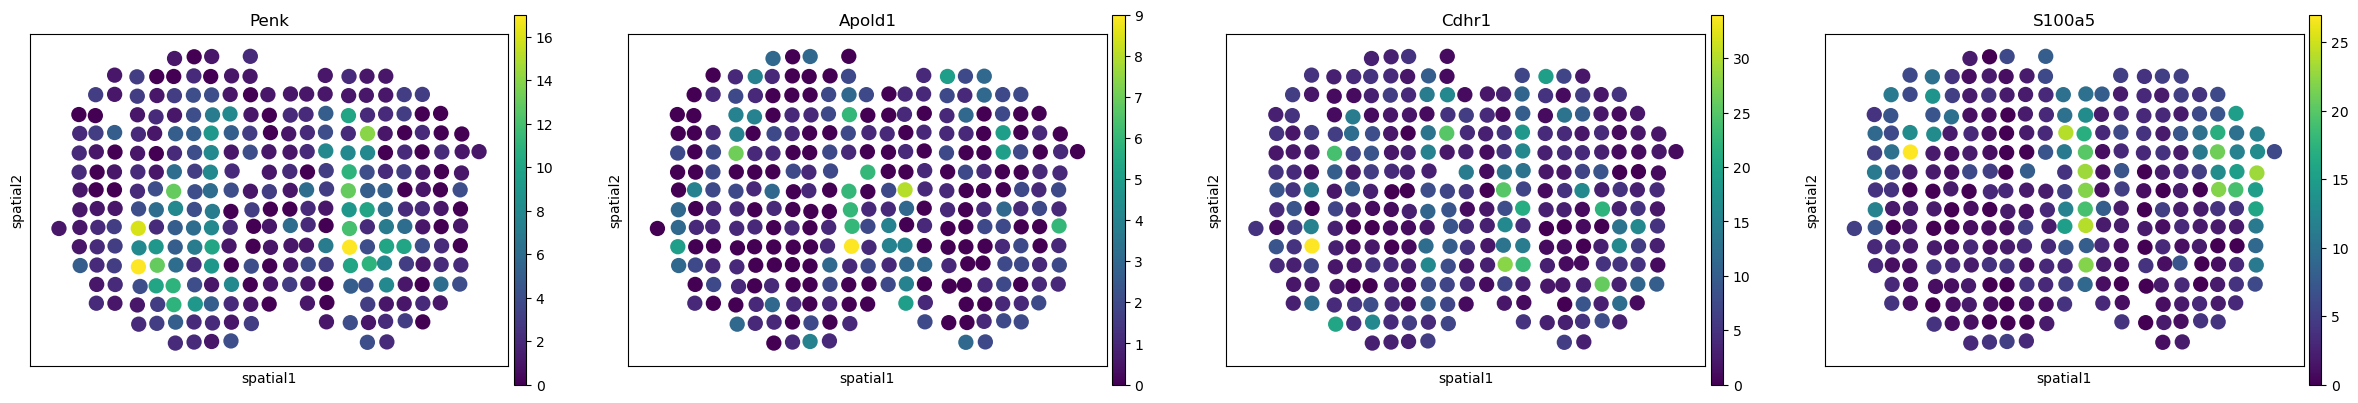

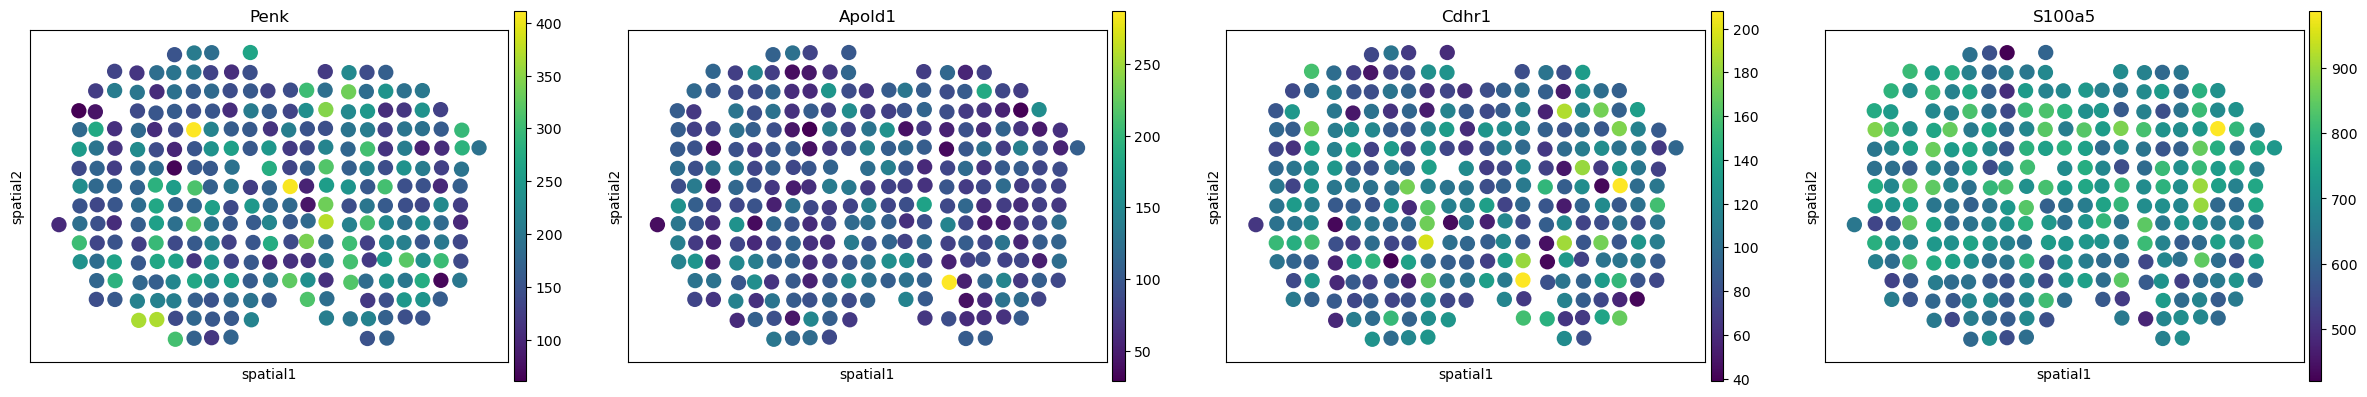

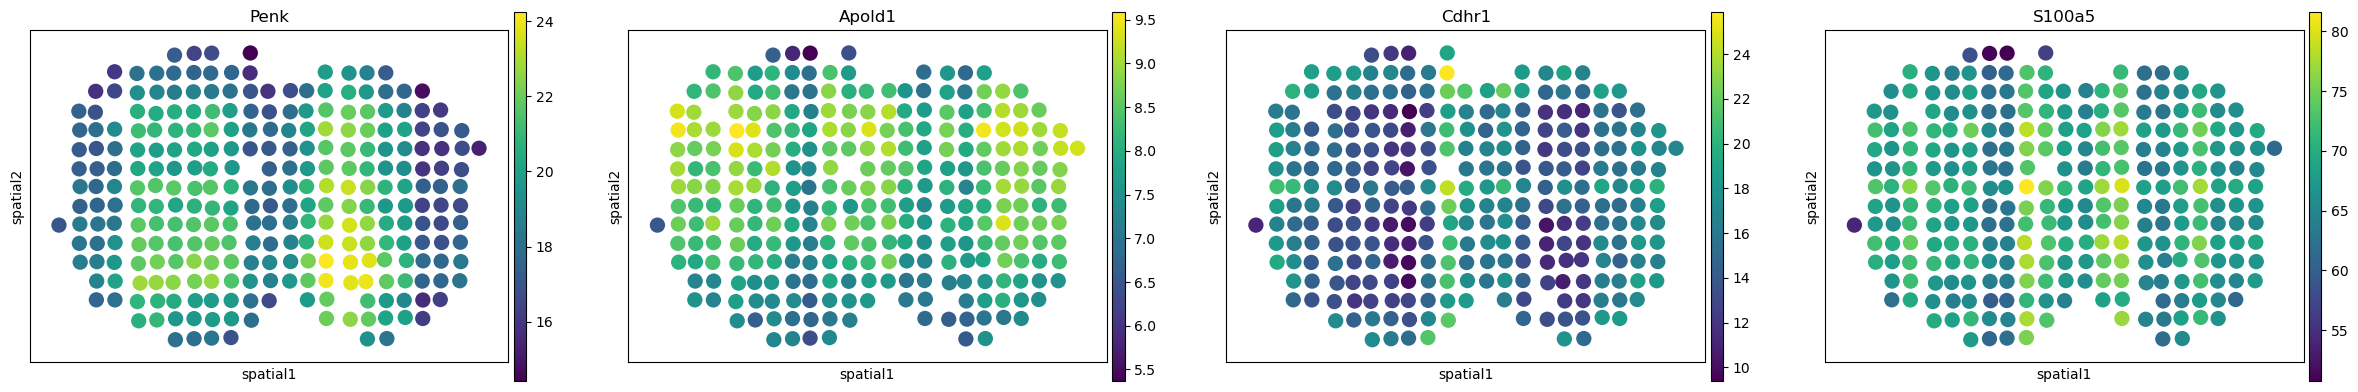

In [13]:
sc.pl.spatial(exper["sp"], color=markers, spot_size=0.8)
sc.pl.spatial(exper["sp_sim"], color=markers, spot_size=0.8)
sc.pl.spatial(exper["sp_sim_sig"], color=markers, spot_size=0.8)